# Tutorial: BAX to improve Accuracy of Interpretability Measures 

In [138]:
from argparse import Namespace

import torch
import numpy as np 
import matplotlib.pyplot as plt 

from botorch.test_functions.synthetic import StyblinskiTang
from botorch.acquisition.algorithm import PDPAlgorithm
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from gpytorch import ExactMarginalLogLikelihood


## Test function 

We have a look at the d-dimensional Styblinski-Tang function 

$$ \frac{1}{2} \sum_{i = 1}^d (x_i^4 - 16 x_i^2 + 5 x_i), x_i \in [-5, 5]. $$

Here $d = 2$ for visualization purposes. 

In [139]:
d = 2
f = StyblinskiTang(dim=d)

In [3]:
x1 = torch.linspace(f.bounds[0][0], f.bounds[1][0], 100)
x2 = torch.linspace(f.bounds[0][1], f.bounds[1][1], 100)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)
Y = f(X).reshape(100, 100).numpy()

/home/julia/miniconda3/envs/botorch-new/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695391896228/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


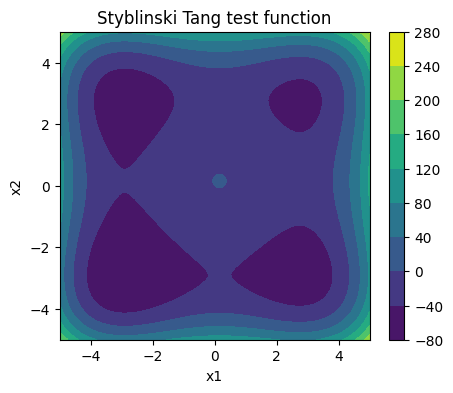

In [4]:
plt.figure(figsize=(5, 4))
plt.contourf(X1.numpy(), X2.numpy(), Y, levels=8)
plt.colorbar()
plt.title('Styblinski Tang test function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

We are interested in visualizing the partial dependence of the function, which is 

$$
    f_1\left(x_1\right) = \int_{X_2} f(x_1, x_2) ~\mathrm{d}\mathbb{P}(x_2)
$$

**Note**: Practically, we would deal with functions of dimensions higher than $2$, which are challenging to visualize directly. Computing the partial dependence allows us to gain insights into these multidimensional functions, making them more interpretable in a visual format.


We run the PDP algorithm on the *true* function $f$. 

In [140]:
params = {"name": "PDP", "xs": 1, "n_points": 50, "bounds": f.bounds, "grid_size": 20}
alg = PDPAlgorithm(params)
alg.initialize()
out = alg.run_algorithm_on_f(f)

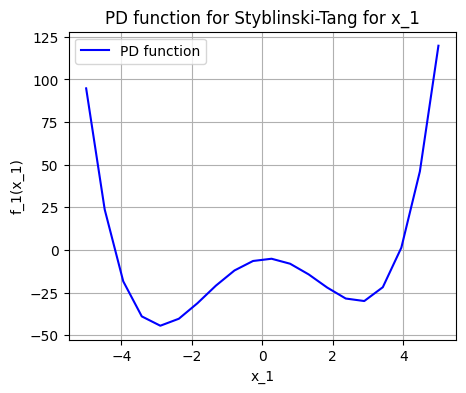

In [66]:
plt.figure(figsize=(5, 4))

x = out[1].x
y = out[1].y
sd = out[1].var.mean()

# Plot the main curve
plt.plot(x, y, label='PD function', color='blue')

# Plot uncertainty bands
# plt.fill_between(x, y - std_dev, y + std_dev, color='blue', alpha=0.2, label='Uncertainty')

# Optional configurations
plt.title('PD function for Styblinski-Tang for x_1')
plt.xlabel('x_1')
plt.ylabel('f_1(x_1)')
plt.legend()
plt.grid(True)

## Black-box Test Functions

In many real-world applications, we deal with functions where we don't have a clear mathematical formula. These "black-box" functions can be expensive or slow to evaluate. In such cases, we might only have a set of sample points, represented as $A_T = \{(x^{(i)}, y^{(i)})\}_{i = 1, ..., T}$, where each $x^{(i)}$ is associated with a function value $y^{(i)}$.

To work with this data, we can fit a model, like a Gaussian Process (GP). This GP can act as an approximation $\hat f$ of the true function, allowing us to make predictions and further analyses.

To illustrate this, let's simulate a scenario. We'll generate samples from a Sobol sequence and use these samples to fit a Gaussian Process.


In [141]:
sobol = SobolEngine(dimension=d, scramble=True, seed=None)

data = Namespace()
X = sobol.draw(n=20).to(dtype=torch.float, device="cpu")
data.x = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * X 
data.y = f(data.x).unsqueeze(0).T

model = SingleTaskGP(train_X=data.x, train_Y=data.y, input_transform=Normalize(d=d), outcome_transform=Standardize(m=1))
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll);


print("Lengthscale:", model.covar_module.base_kernel.lengthscale)
print("Outputscale:", model.covar_module.outputscale)
print("Noise:", model.likelihood.noise)


Lengthscale: tensor([[0.3212, 0.1747]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Outputscale: tensor(1.5639, dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Noise: Parameter containing:
tensor([0.0095], dtype=torch.float64, requires_grad=True)


Instead of visualizing the PD of $f$, we visualize the PD of $\hat f$. 

In [142]:
from botorch.acquisition.bax import InfoBAX

params = {"name": "BAX", "n_path": 3, "num_mv_samples": 10}
EIG = InfoBAX(params=params, model=model, algorithm=alg)

*[TIME] [Sample 3 execution paths] Elapsed: 68.74 seconds


In [143]:
out_approx = EIG.output_list[0]

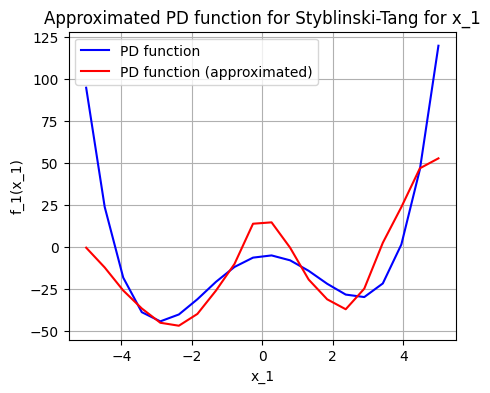

In [144]:
plt.figure(figsize=(5, 4))

x_approx = out_approx.x.tolist()
y_approx = out_approx.y.tolist()

# Plot the main curve
plt.plot(x, y, label='PD function', color='blue')
plt.plot(x_approx, y_approx, label='PD function (approximated)', color='red')

# Optional configurations
plt.title('Approximated PD function for Styblinski-Tang for x_1')
plt.xlabel('x_1')
plt.ylabel('f_1(x_1)')
plt.legend()
plt.grid(True)

**Key question**: What are the best samples $(x_{(i)}, y_{(i)})$ to approximated the PD function best? 

## Expected information gain

We would like to compute the expected information gain (EIG) of a point $\bm{\tilde x}$ on the algorithm output $\mathcal{O}_\mathcal{A}$ (i.e., the PDP). 

The formula for this is: 

$$
    \textrm{EIG}^e_T(\mathbf{x}) = \underbrace{\mathbb{H}\left[f_{\mathbf{x}}|A_T\right]}_{(1)} - \underbrace{\mathbb{E}_{e_{\mathcal{A}}|A_T}\left[\mathbb{H}\left[f_{\mathbf{x}}|A_T, e_\mathcal{A}\right]\right]}_{(1)}
$$


Here, $e_\mathcal{A}$ is the execution path, i.e., the sequence of all evaluations the PDP algorithm $\mathcal{A}$ traverses, which gives full information about the output $\mathcal{O}_\mathcal{A}$ of the PDP algorithm. 



Let's say we want to compute the information gain of a randomly drawn point $\bm{\tilde x}$. 


#### Expected information gain: Part (1)

Let's take it step by and look at part (1) of this formula. That is pretty easy to compute as this is just the entropy of our posterior predictive distribution at an input $\bm{\tilde x}$ and it can be computed in [closed form](https://gregorygundersen.com/blog/2020/09/01/gaussian-entropy/): 

$$
    \mathbb{H}\left[f_{\mathbf{x}}|A_T\right] = \frac{1}{2}\log(2 \pi \sigma^2) + \frac{1}{2}
$$

with $f_x \sim \mathcal{N}\left(\mu, \sigma^2\right)$ with $\mu = m_\textrm{post}(\bm{\tilde x}), \sigma^2 = k_\textrm{post}(\bm{\tilde x}, \bm{\tilde x})$. 

In [145]:
X = torch.rand(1, d, device="cpu", dtype=torch.float)

posterior = model.posterior(
    X.unsqueeze(-3), observation_noise=False, posterior_transform=None
)

mu = posterior.mean
sigma2 = posterior.variance.detach().numpy().flatten()


In [146]:
h_post = 0.5 * np.log(2 * np.pi * sigma2) + 0.5
h_post

array([4.19024185])

#### Expected information gain: Part (2)

The second part is trickier to compute 

$$
    \mathbb{E}_{e_{\mathcal{A}}|A_T}\left[\mathbb{H}\left[f_{\mathbf{x}}|A_T, e_\mathcal{A}\right]\right]
$$

* We cannot compute the expected value analytically; instead, we sample $n_{\textrm{path}}$ samples of the execution path $e_A$, and approximate the expression via a mean estimator.  

* We do not have $f_{\mathbf{x}}|A_T, e_A$ readily available; we need to fit the posterior process $f_{\mathbf{x}}|A_T, e_A$ before computing the entropy. 

In our case, let's say $n_\textrm{path} = 3$ (typically we would set this higher). The acquisition function samples $n_\textrm{path}$ execution path samples (which correspond to realizations of a PDP).  

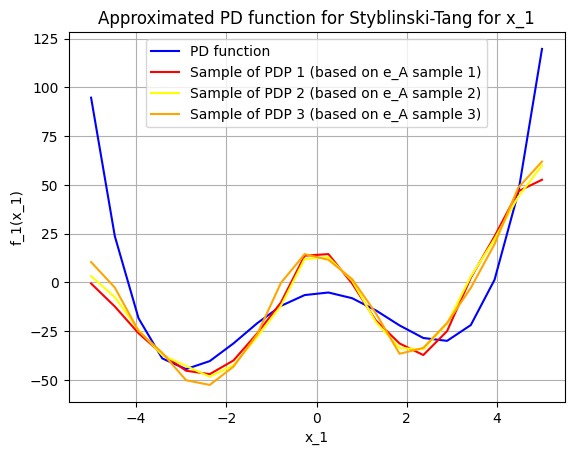

In [164]:
# Plot the main curve
plt.plot(x, y, label='PD function', color='blue')
plt.plot(EIG.output_list[0].x.tolist(), EIG.output_list[0].y.tolist(), label='Sample of PDP 1 (based on e_A sample 1)', color='red')
plt.plot(EIG.output_list[1].x.tolist(), EIG.output_list[1].y.tolist(), label='Sample of PDP 2 (based on e_A sample 2)', color='yellow')
plt.plot(EIG.output_list[2].x.tolist(), EIG.output_list[2].y.tolist(), label='Sample of PDP 3 (based on e_A sample 3)', color='orange')

# Optional configurations
plt.title('Approximated PD function for Styblinski-Tang for x_1')
plt.xlabel('x_1')
plt.ylabel('f_1(x_1)')
plt.legend()
plt.grid(True)

Now, we do re-fits of the model and compute the posterior $f_x ~|~ A_T, e_A$. For each of the execution path samples we can compute the posterior. 

For illustration purposes, we do that manually (while in reality, the acquisition function performs this internally) for one of the execution paths. 

In [173]:
exe_path = EIG.exe_path_full_list[0]

exe_path_new = Namespace()

# 1. Merge (D, eA)
exe_path_new.x = torch.stack(exe_path.x).to(dtype=torch.float)
exe_path_new.y = torch.stack(exe_path.y).to(dtype=torch.float).detach()

# (A_T, e_a) as combined dataset 
comb_data = Namespace()
comb_data.x = torch.cat((data.x, exe_path.x), 0)
comb_data.y = torch.cat((data.y, exe_path.y), 0)

# Fit the posterior process f_x | (A_T, e_a) 
model_new = SingleTaskGP(train_X=comb_data.x, train_Y=comb_data.y, input_transform=Normalize(d=d), outcome_transform=Standardize(m=1))
mll = ExactMarginalLogLikelihood(model_new.likelihood, model_new)
fit_gpytorch_mll(mll);

TypeError: expected Tensor as element 1 in argument 0, but got list

In [134]:
# Now compute the entropy based on this model
posterior_samp = model_new.posterior(X)     

# # 2. Computer posterior y_x | (D, eA)
# posterior_samp = model_new.posterior(X)
std_samp = posterior_samp.variance.detach().numpy().flatten()

# 3. Formula for entropy 
h_samp = np.log(std_samp) + np.log(np.sqrt(2 * np.pi)) + 0.5

h_samp

array([4.73525345])

#### Computation of the acquisition function

Now that we got the acquisition function together, we can compute it's value for a candidate $\mathbf{\tilde x}$. 

In [174]:
EIG.forward(X)

array([2.64169387])

Now let's compute it for a bunch of candidate points and let's see what is the best one to pick! 

In [189]:
candidate_set = torch.rand(50, d, device="cpu", dtype=torch.float)
candidate_set = f.bounds[0,:] + (f.bounds[1,:] - f.bounds[0,:]) * candidate_set


In [190]:
acq_values = EIG.forward(candidate_set)
acq_values 

array([ 3.07501259,  3.45757027,  2.9378911 ,  3.72437094,  2.95837925,
        3.09493912,  1.64031117,  3.26968958,  3.18334318,  2.55999947,
        1.16379625,  2.60357084,  2.54366542,  3.7539994 , -0.01656351,
        3.49688143,  3.1527119 ,  3.15166218,  2.43456303,  4.19840278,
        2.82520307,  0.51330931,  2.21202157,  1.53364778,  0.74248492,
        3.32598823,  3.24977562,  3.28495214,  2.87348499,  2.45964655,
        3.31609627,  2.101692  ,  4.31986164,  2.96359538,  1.84912937,
        3.19234113,  1.43222149,  2.84942391,  2.47054078,  0.77861001,
        2.1883589 ,  3.41886683,  2.79228684,  2.6536735 ,  3.19150242,
        1.82085917,  1.48510104,  3.00905005,  1.5522356 ,  4.11736953])

In [191]:
x1 = torch.linspace(f.bounds[0][0], f.bounds[1][0], 100)
x2 = torch.linspace(f.bounds[0][1], f.bounds[1][1], 100)
X1, X2 = torch.meshgrid(x1, x2)
X = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

model.eval()
with torch.no_grad():
    post = model.posterior(X)
    mean = post.mean.cpu().numpy()
    variance = post.variance.cpu().numpy()
    std_dev = torch.sqrt(post.variance).cpu().numpy()

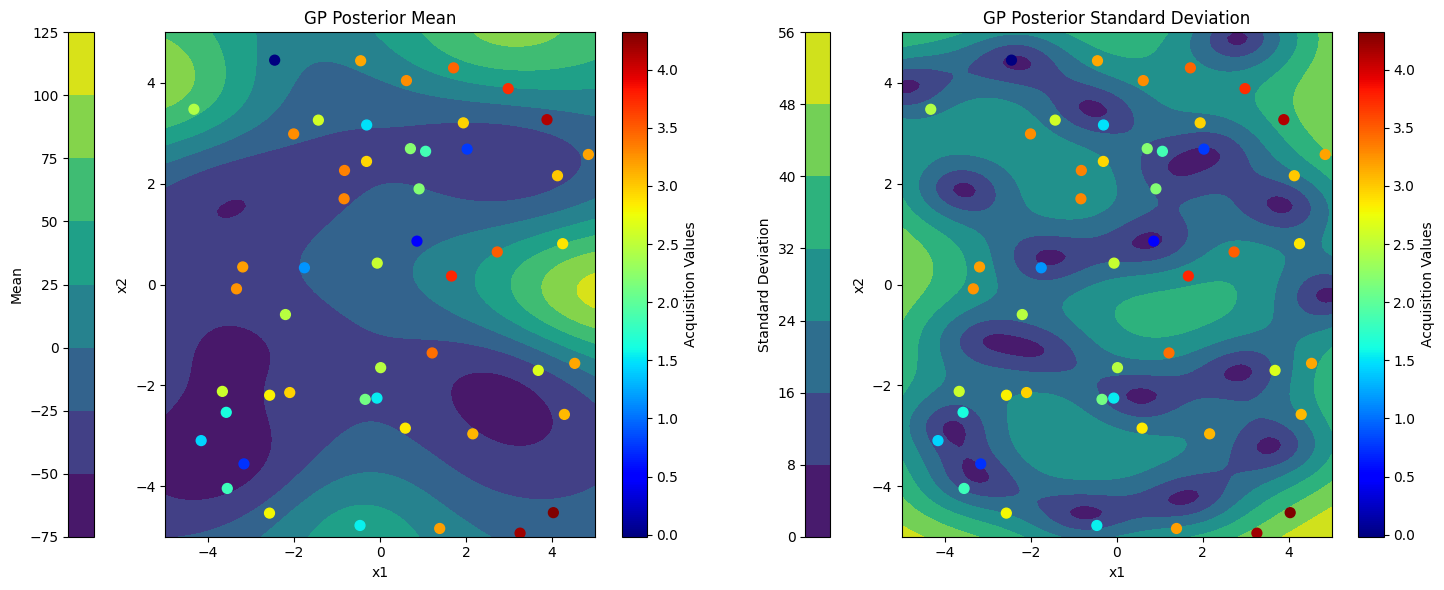

In [192]:
import matplotlib.pyplot as plt
import numpy as np

fig, axarr = plt.subplots(1, 2, figsize=(15, 6))

# Plot mean on the left subplot
contour_mean = axarr[0].contourf(X1.numpy(), X2.numpy(), mean.reshape(100, 100))
cbar_mean = fig.colorbar(contour_mean, ax=axarr[0], location='left')
cbar_mean.ax.set_ylabel('Mean')
axarr[0].set_title("GP Posterior Mean")
axarr[0].set_xlabel("x1")
axarr[0].set_ylabel("x2")

# Overlay training data on the mean plot
scatter_points = axarr[0].scatter(candidate_set[:, 0].numpy(), candidate_set[:, 1].numpy(), c=acq_values, cmap='jet', s=50, zorder=10, label='Training Data')
cbar_points_mean = fig.colorbar(scatter_points, ax=axarr[0], location='right')
cbar_points_mean.ax.set_ylabel('Acquisition Values')

# Plot standard deviation on the right subplot
contour_std = axarr[1].contourf(X1.numpy(), X2.numpy(), std_dev.reshape(100, 100))
cbar_std = fig.colorbar(contour_std, ax=axarr[1], location='left')
cbar_std.ax.set_ylabel('Standard Deviation')
axarr[1].set_title("GP Posterior Standard Deviation")
axarr[1].set_xlabel("x1")
axarr[1].set_ylabel("x2")

# Overlay training data on the standard deviation plot
scatter_points_std = axarr[1].scatter(candidate_set[:, 0].numpy(), candidate_set[:, 1].numpy(), c=acq_values, cmap='jet', s=50, zorder=10, label='Training Data')
cbar_points_std = fig.colorbar(scatter_points_std, ax=axarr[1], location='right')
cbar_points_std.ax.set_ylabel('Acquisition Values')

plt.tight_layout()
plt.show()
